In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import os 

In [5]:
df = pd.read_csv("./bbc/category.csv")
# name of catagory is not correct in csv , so changing it
df = df.rename(columns = {"catagory": "category"}) 
# removing unnecessry unnnamed collumn
df = df.drop(columns=['Unnamed: 0'])
# we only want catagory content and codes 
req_col = ["category" , "content"]
df = df[req_col]

df['codes'] = df['category'].factorize()[0]
category_codes_df = df[['category', 'codes']].drop_duplicates().sort_values('codes')
category_to_codes = dict(category_codes_df.values)
codes_to_category = dict(category_codes_df[['codes', 'category']].values)
df.head()

,category,content,codes
0,politics,The ultimate prize of 10 Downing Street may co...,0
1,politics,Tony Blair has dismissed reports he told Gordo...,0
2,politics,A general election is the best chance most pre...,0
3,politics,Tony Blair and Gordon Brown are desperately tr...,0
4,politics,Anglers and fishermen could find themselves pr...,0


,category,content,codes
1800,business,Beyond the desperate security situation in Ira...,3


sport_code = 3; politics_code = 2; entertainment_code = 1; business_code = 0; tech_code = 4;
    1.)sublinear_df is set to True to use a logarithmic form for frequency.
    2.)min_df is the minimum numbers of documents a word must be present in to be kept.
    3.)norm is set to l2, to ensure all our feature vectors have a euclidian norm of 1.
    4.)ngram_range is set to (1, 2) to indicate that we want to consider both unigrams and bigrams.
    5.)stop_words is set to "english" to remove all common pronouns ("a", "the", ...) to reduce the number of noisy features.

In [13]:
# Genrating feature vectors 
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')
features = tfidf.fit_transform(df.content).toarray()
labels = df.codes
features.shape

(2225, 14261)

In [14]:
df.head()

,category,content,codes
0,politics,The ultimate prize of 10 Downing Street may co...,0
1,politics,Tony Blair has dismissed reports he told Gordo...,0
2,politics,A general election is the best chance most pre...,0
3,politics,Tony Blair and Gordon Brown are desperately tr...,0
4,politics,Anglers and fishermen could find themselves pr...,0


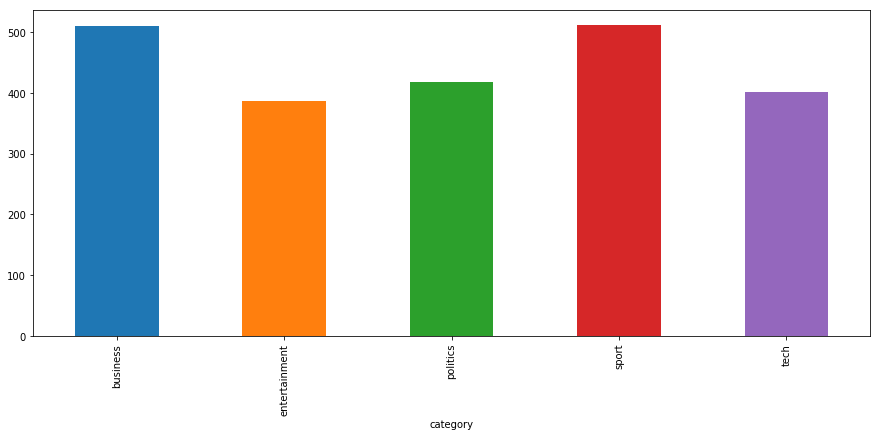

In [15]:
# checking if the data is balanced or not 
fig = plt.figure(figsize=(15,6))
df.groupby('category').content.count().plot.bar(ylim=0)
plt.show()

In [18]:
# Feature selecting or Feature reduction 
# Finding what are the all most common words there in the corpus
# sklearn.feature_selection.chi2 to find the terms that are the most correlated with each of the products
from sklearn.feature_selection import chi2

N = 10
for Product, category_id in sorted(category_to_codes.items()):
      features_chi2 = chi2(features, labels == category_id)
      indices = np.argsort(features_chi2[0])
      feature_names = np.array(tfidf.get_feature_names())[indices]
      unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
      bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
      print("# '{}':".format(Product))
      print("  . Most correlated unigrams:\n. {}".format('\n. '.join(unigrams[-N:])))
      print("  . Most correlated bigrams:\n. {}".format('\n. '.join(bigrams[-N:])))

# 'business':
  . Most correlated unigrams:
. analysts
. market
. economic
. prices
. stock
. economy
. bank
. oil
. growth
. shares
  . Most correlated bigrams:
. bank england
. central bank
. fourth quarter
. consumer spending
. stock exchange
. chief executive
. oil prices
. analysts said
. stock market
. economic growth
# 'entertainment':
  . Most correlated unigrams:
. oscar
. festival
. actress
. band
. album
. award
. singer
. awards
. actor
. film
  . Most correlated bigrams:
. best actress
. best director
. dollar baby
. best film
. named best
. won best
. million dollar
. film festival
. los angeles
. box office
# 'politics':
  . Most correlated unigrams:
. leader
. chancellor
. minister
. secretary
. tories
. tory
. party
. blair
. election
. labour
  . Most correlated bigrams:
. lib dems
. liberal democrats
. home secretary
. mr howard
. michael howard
. mr brown
. general election
. prime minister
. tony blair
. mr blair
# 'sport':
  . Most correlated unigrams:
. game
. te

/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed

/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


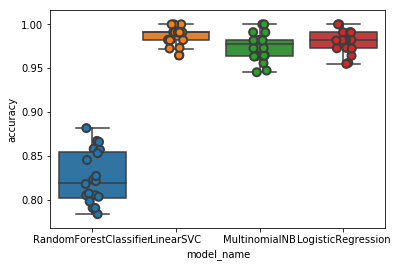

In [22]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB

from sklearn.model_selection import cross_val_score

models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]
CV = 20
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
      model_name = model.__class__.__name__
      accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
      for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

import seaborn as sns

sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()